# RNN 

In [1]:
import torch
import torchvision                          # torch package for vision related things
import torch.nn.functional as F             # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets     # Standard datasets
import torchvision.transforms as transforms # Transformations we can perform on our dataset for augmentation
from torch import optim                     # For optimizers like SGD, Adam, etc.
from torch import nn                        # All neural network modules
from torch.utils.data import DataLoader     # Gives easier dataset management by creating mini batches etc.
from tqdm import tqdm                       # For a nice progress bar!
import matplotlib.pyplot as plt             # For Plots

/home/sannin/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Character-wise RNN

In [23]:
!mkdir -p Datasets/Character-RNN

In [22]:
# !wget https://download.pytorch.org/tutorial/data.zip -P Datasets/Character-RNN
!unzip Datasets/Character-RNN/data.zip -d Datasets/Character-RNN/

Archive:  Datasets/Character-RNN/data.zip
   creating: Datasets/Character-RNN/data/
  inflating: Datasets/Character-RNN/data/eng-fra.txt  
   creating: Datasets/Character-RNN/data/names/
  inflating: Datasets/Character-RNN/data/names/Arabic.txt  
  inflating: Datasets/Character-RNN/data/names/Chinese.txt  
  inflating: Datasets/Character-RNN/data/names/Czech.txt  
  inflating: Datasets/Character-RNN/data/names/Dutch.txt  
  inflating: Datasets/Character-RNN/data/names/English.txt  
  inflating: Datasets/Character-RNN/data/names/French.txt  
  inflating: Datasets/Character-RNN/data/names/German.txt  
  inflating: Datasets/Character-RNN/data/names/Greek.txt  
  inflating: Datasets/Character-RNN/data/names/Irish.txt  
  inflating: Datasets/Character-RNN/data/names/Italian.txt  
  inflating: Datasets/Character-RNN/data/names/Japanese.txt  
  inflating: Datasets/Character-RNN/data/names/Korean.txt  
  inflating: Datasets/Character-RNN/data/names/Polish.txt  
  inflating: Datasets/Character-

Arabic
5000 5.0 2.7299 Stewart / Polish WRONG (Scottish)
10000 10.0 2.2412 Herbert / Dutch WRONG (German)
15000 15.0 2.5269 Gray / Arabic WRONG (Scottish)
20000 20.0 0.9320 Yuan / Chinese CORRECT
25000 25.0 2.0377 Tremble / Scottish WRONG (French)
30000 30.0 2.8862 Ross / Greek WRONG (Scottish)
35000 35.0 0.1433 Forakis / Greek CORRECT
40000 40.0 3.1363 Konae / Czech WRONG (Japanese)
45000 45.0 1.1502 Bruce / Scottish CORRECT
50000 50.0 3.0244 Stauss / Greek WRONG (German)
55000 55.00000000000001 1.5722 Binnington / Scottish WRONG (English)
60000 60.0 1.5705 Dieter / French WRONG (German)
65000 65.0 1.2691 Lieu / Vietnamese CORRECT
70000 70.0 2.9259 Pan / Vietnamese WRONG (French)
75000 75.0 2.0390 Otani / Italian WRONG (Japanese)
80000 80.0 0.3414 Ansaldi / Italian CORRECT
85000 85.0 1.0352 Frierdich / Czech CORRECT
90000 90.0 2.6023 Whelan / Scottish WRONG (Irish)
95000 95.0 1.2664 Nakane / Japanese CORRECT
100000 100.0 1.1729 Acosta / Italian WRONG (Spanish)


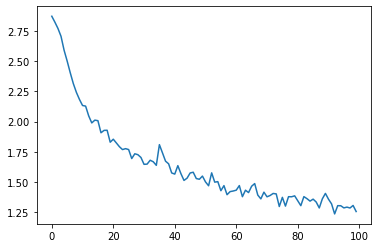

In [19]:
from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example


class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
#print(output.size())
#print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
#print(output.size())
#print(next_hidden.size())

def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")
        
    
plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)
    

In [10]:
while True:
    sentence = input("Input:")
    if sentence.strip() == "quit" or sentence.strip() == "":
        break
    
    predict(sentence)


> Bélanger
French

> Albert
French

> Duong
Vietnamese

> Duong
Vietnamese

> Vuu
Vietnamese

> Belesis
Greek

> Belesis
Greek

> Breda
Spanish

> Breda
Spanish

> Agthoven
Dutch

> Kloet
Dutch


# LSTM

## Sentiment Analysis using IMDB dataset

In [24]:
# Imports
import torch
import torch.nn.functional as F
import torchtext
from torchtext import data
from torchtext.datasets import imdb
import time
import random
# import pandas as pd
from torchtext.vocab import vocab
from collections import Counter, OrderedDict

torch.backends.cudnn.deterministic = True

### Hyperparameters

In [34]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

### Dataset Prep

In [ ]:
# !wget https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz
# !gunzip -f movie_data.csv.gz 

In [ ]:
# df = pd.read_csv('movie_data.csv')
# print(df.head())
# del df

In [ ]:
# !python -m spacy download en_core_web_sm

In [44]:
# ### Defining the feature processing

# TEXT = torchtext.data.field(
#     tokenize='spacy', # default splits on whitespace
#     tokenizer_language='en_core_web_sm'
# )

# ### Defining the label processing

# LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)

# fields = [('TEXT_COLUMN_NAME', TEXT), ('LABEL_COLUMN_NAME', LABEL)]

# ### Process the dataset
# dataset = torchtext.legacy.data.TabularDataset(
#     path='movie_data.csv', format='csv',
#     skip_header=True, fields=fields)

In [4]:
torchtext.__version__

'0.12.0'

In [5]:
!mkdir -p Datasets/LSTM

In [6]:
train_data, test_data = imdb.IMDB(root="Datasets/LSTM/", split=('train','test'))

/home/sannin/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/sannin/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/selecting.py:54: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn("Lambda function is not supported for pickle, please use "


In [48]:
line_tokens = []
label_tokens = []
def tokenize(line):
    return line.split()
for label, line in train_data:
    line_tokens += tokenize(line)
    label_tokens += tokenize(label)

print(line_tokens[:10])
print(label_tokens[:10])

['Zentropa', 'has', 'much', 'in', 'common', 'with', 'The', 'Third', 'Man,', 'another']
['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos']


In [54]:
unk_token = '<unk>'
default_index = -1
line_vocab = vocab(OrderedDict([(token, 1) for token in line_tokens]), specials=[unk_token])
line_vocab = line_vocab.to(DEVICE)
line_vocab.set_default_index(default_index)
print(line_vocab['<unk>']) #prints 0
print(line_vocab['out of vocab']) #prints -1
#make default index same as index of unk_token
line_vocab.set_default_index(line_vocab[unk_token])
line_vocab['out of vocab'] is line_vocab[unk_token] #prints True

label_vocab = vocab(OrderedDict([(token, 1) for token in label_tokens]))
label_vocab = label_vocab.to(DEVICE)


0
-1


In [55]:
print(line_vocab.get_itos()[:10])
print(line_vocab.get_stoi()['has'])
print(label_vocab.get_itos())
print(label_vocab.get_stoi())

['<unk>', 'Zentropa', 'has', 'much', 'in', 'common', 'with', 'The', 'Third', 'Man,']
2
['pos', 'neg']
{'neg': 1, 'pos': 0}
Vocab()


2

# References

* https://www.coursera.org/learn/nlp-sequence-models
* https://github.com/cedricdeboom/character-level-rnn-datasets
* https://github.com/MycroftAI/rnn-demo
* https://github.com/python-engineer/pytorch-examples/tree/master/rnn-name-classification
* https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L15/1_lstm.ipynb
* https://github.com/aladdinpersson/Machine-Learning-Collection
* https://towardsdatascience.com/rnn-recurrent-neural-networks-how-to-successfully-model-sequential-data-in-python-5a0b9e494f92
* https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn
* https://github.com/python-engineer/pytorch-examples/tree/master/rnn-lstm-gru